In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn
import mne
from mne.viz import plot_topomap
import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

from scipy.stats import ttest_1samp
from scipy.optimize import minimize
from statsmodels.stats.multitest import multipletests

import pyabc

# some metadata
SNRs = np.array([-np.inf,-13,-11,-9,-7,-5,-3])
SubIDs = ['01','02','03','05','06','07','08','09','11','12','13','14','15','17','19','20','22','23','24','25']
colormap = {0: (0, 0, 0), 1: (0, 0.25, 1), 2: (0, 0.9375, 1), 3: (0, 0.91, 0.1), 4: (1, 0.6, 0), 5: (1, 0, 0), 6: (0.8, 0, 0)}

print(os.getcwd())

/srv/elefanto/ConsciousnessTeam_Data/SOUNDMODEL


In [2]:
part = 13

# 1: Reproducing classical TempGen

In [2]:
def plot_TG_matrix(time_series, cat, baseline_correction=True, save_path=None):
    tgmatrix = np.mean(time_series[cat], 0)
    baseline = np.mean(time_series[0], 0) if baseline_correction else np.zeros(np.shape(time_series[0][0]))
    plt.figure()
    plt.imshow(tgmatrix[30:200,30:200] - baseline[30:200,30:200], aspect='equal', cmap="RdBu_r", origin='lower', extent=[-200, 1500, -200, 1500], vmin=-0.7, vmax=2.2)
    plt.xlabel('Application time (ms)')
    plt.ylabel('Training time (ms)')
    plt.colorbar(label='AVG predictor')
    plt.title(f'Temporal Generalisation, cat {cat}')
    plt.savefig(save_path) if save_path != None else None
    plt.show()

Reading /srv/elefanto/ConsciousnessTeam_Data/SOUNDMODEL/Data_SoundGOOD/myEpochs_Passive/Epoch_17-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1998.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
1035 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_1553603/1062549200.py:2: RuntimeWarning: The measurement information indicates a low-pass frequency of 250.0 Hz. The decim=5 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.read_epochs(data_ref, preload=True).decimate(5)


Fit...
Applies to data...


  0%|          | 0/6 [00:00<?, ?it/s]

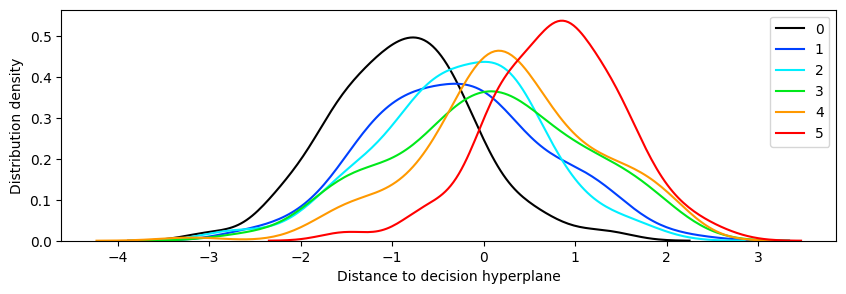

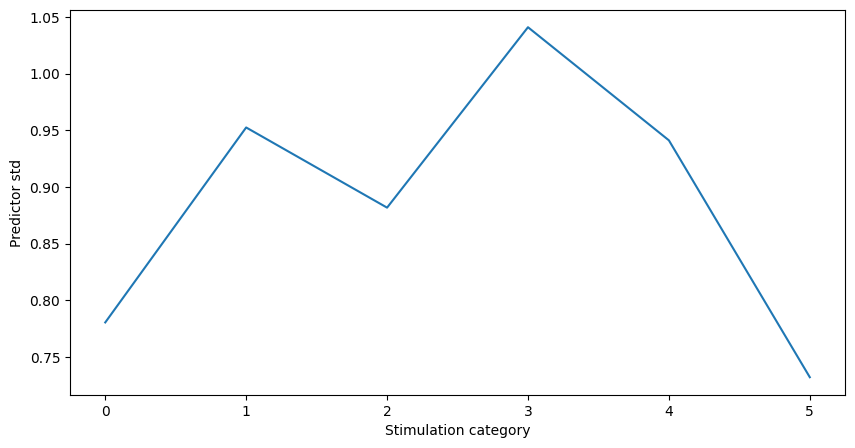

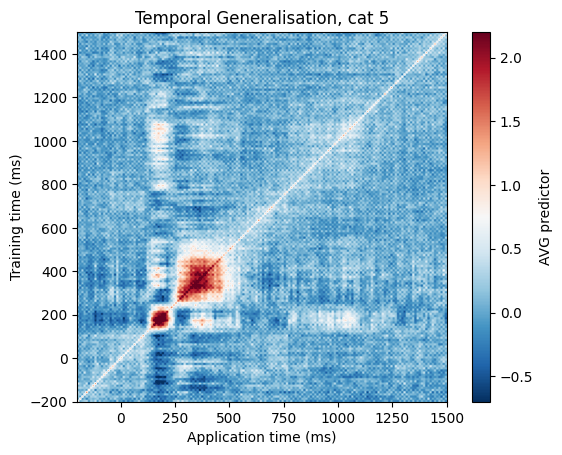

In [4]:
data_ref = 'Data_SoundGOOD/myEpochs_Passive/Epoch_'+SubIDs[part]+'-epo.fif'
epochs = mne.read_epochs(data_ref, preload=True).decimate(5)

stim_pres_epochs = epochs['6']
stim_abs_epochs = epochs['1']
combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)

X = combined_epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
y = np.where(combined_epochs.events[:, 2] == 1, 0, 1)

clf = make_pipeline(
    Scaler(combined_epochs.info, scalings='mean'),
    Vectorizer(),
     LinearModel(LogisticRegression(penalty='l2', solver="liblinear")),  # liblinear is faster than lbfgs
)

# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=10, scoring="roc_auc", verbose=False)

# fit and output distance to the decision hyperplane
print('Fit...')
time_gen.fit(X,y)

time_series = {}

# distributions
print('Applies to data...')
stds = []
plt.figure(figsize=(10,3))
for cat in tqdm(range(6)):
    preds = time_gen.decision_function(epochs[str(cat+1)].get_data())
    time_series[cat] = preds
    # np.save(f'TemporalGeneralization/TG_C{i}_{field}_{cat[-4:]}_AllTrials.npy', preds)
    # preds_slice = np.mean(preds[:,95:105,:],-2)
    # preds_square = -np.mean(preds_slice[:,90:100], 1)
    preds_diag = np.array([np.mean(np.diag(trial[90:100,90:100])) for trial in preds])
    stds.append(np.std(preds_diag))
    seaborn.kdeplot(data=preds_diag,label=str(cat),color=colormap[cat])
plt.xlabel('Distance to decision hyperplane')
plt.ylabel('Distribution density')
plt.legend()
# plt.title(f'Distribution of decoding scores between 448 and 547 ms post-stim, C{i}, {field}.')
# plt.savefig(f'BifurcationDistributions/C{i}_{field}_448to547ms.png')
plt.show()

# stds
# stds_all_parts.append(stds)
plt.figure(figsize=(10,5))
plt.plot([0,1,2,3,4,5], stds)
plt.xlabel('Stimulation category')
plt.ylabel('Predictor std')
# plt.title(f'STD of decoding scores between 448 and 547 ms post-stim, C{i}, {field}.')
# plt.savefig(f'BifurcationDistributions/C{i}_{field}_448to547ms_stds.png')
plt.show()


# plot TG matrix
plot_TG_matrix(time_series, cat=5)

[5, 5]


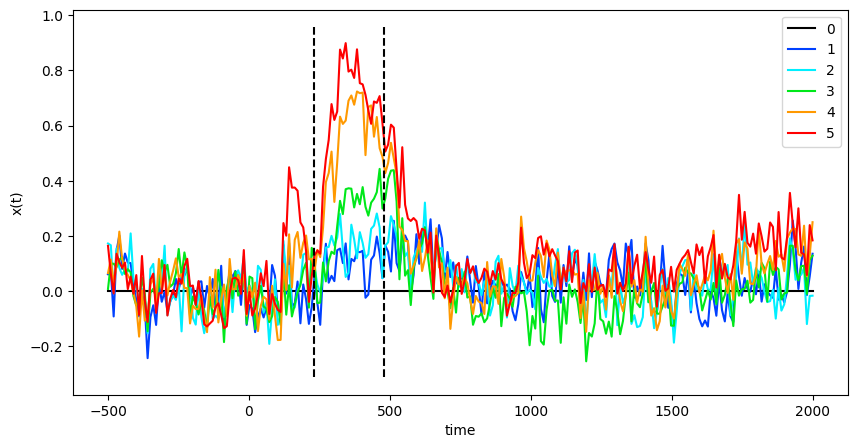

In [5]:
# plot trajectories
def plot_phase_trajectories(time_series, trials, training_time=None, avg=False, SGfilter=False, compare=False, cursor=None, save_path=None, train_steps=[5,5]):
    '''
    - "trials" is a dict with categories as keys and trial arrays as elements.
    Ex : trials = {0 : [0, 1, 2], 5 : [0, 1, 2, 3, 4]}.
    - "compare" is True for comparing filtered and not filtered trajectories.
    '''
    nb_timepoints = len(time_series[list(time_series.keys())[0]][0,training_time]) if training_time != None else len(time_series[list(time_series.keys())[0]][0])
    times = np.linspace(-500, 2000, nb_timepoints)
    categories = time_series.keys()
    print(train_steps)
    time_series = {cat : np.mean(time_series[cat][:,training_time-train_steps[0]:training_time+train_steps[1],:],-2) for cat in categories} if training_time != None else time_series
    plt.figure(figsize=(10,5))
    for cat in trials.keys() :
        plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat],label=str(cat)) if avg and not(SGfilter) else None
        if SGfilter and avg :
            all_filtered = scipy.signal.savgol_filter(time_series[cat], window_length=wl, polyorder=po, deriv=0, axis=-1)
            plt.plot(times, np.mean(all_filtered,0),color=colormap[cat],label=str(cat))
        for traj_nb in trials[cat] :
            if SGfilter :
                plt.plot(times, time_series[cat][traj_nb], color='gray', linestyle=None) if compare else None
                filtered = scipy.signal.savgol_filter(time_series[cat][traj_nb], window_length=wl, polyorder=po, deriv=0, axis=-1)
                plt.plot(times, filtered, linestyle=':' if avg else None, color=colormap[cat] if len(list(trials.keys()))>1 else None)
            else :
                plt.plot(times, time_series[cat][traj_nb], linestyle=':' if avg else None, color=colormap[cat] if len(list(trials.keys()))>1 else None)
    if cursor != None:
        xmin, xmax = plt.ylim()
        for value in cursor : 
            plt.plot([value, value], [xmin, xmax], linestyle='--', color='black')
    plt.xlabel('time')
    plt.ylabel('x(t)')
    plt.legend()
    plt.savefig(save_path) if save_path != None else None
    plt.show()


time_series_bc = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in time_series.keys()}
plot_phase_trajectories(time_series_bc, trials={0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : []}, training_time=100, avg=True, SGfilter=False, compare=False, cursor=[480, 230],
                                save_path=None)

# 2: Segmented Temporal Generalization

## 2.1: Defining the late process time window from the classical TG matrix

Z.shape = (250, 250)


Find best 2D Gaussian...:   0%|          | 0/936 [00:00<?, ?it/s]

Best params : (np.int64(68), np.float64(2.9899908945071783), np.int64(87), np.float64(9.274711083757902)), hence best times : (np.int64(370), np.int64(180)) ms pso.


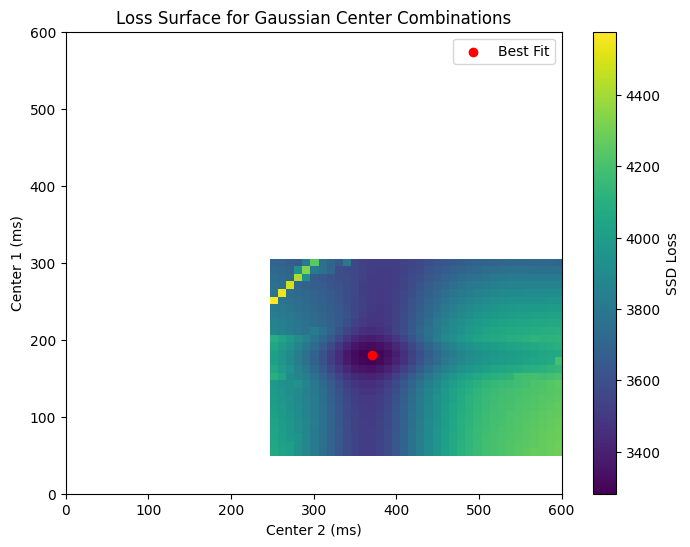

In [8]:
from scipy.optimize import minimize
from itertools import product

# TG matrix for category 5
Z = np.mean(time_series[5], 0) - np.mean(time_series[0], 0)
print(f'Z.shape = {Z.shape}')

def gaussian_2d(X, Y, xc, sigma):
    return np.exp(-((X - xc)**2 + (Y - xc)**2) / (2 * sigma**2))

def model_fit(params, X, Y, Z, centers):
    sigma1, sigma2 = params
    G1 = gaussian_2d(X, Y, centers[0], sigma1)
    G2 = gaussian_2d(X, Y, centers[1], sigma2)
    
    # Estimate amplitudes via least squares
    G_stack = np.stack([G1.ravel(), G2.ravel()], axis=1)
    A, _, _, _ = np.linalg.lstsq(G_stack, Z.ravel(), rcond=None)
    
    Z_pred = A[0] * G1 + A[1] * G2
    return np.sum((Z - Z_pred)**2)

def fit_gaussians(Z, x1_range, x2_range, sigma_bounds=(1, 30)):
    H, W = Z.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))

    score_matrix = np.full((61, 61), np.inf)
    best_loss = np.inf
    best_params = None

    for x1, x2 in tqdm(product(x1_range, x2_range), total=len(x1_range)*len(x2_range), leave=False, desc='Find best 2D Gaussian...'):
        res = minimize(
            model_fit,
            x0=[5.0, 5.0],
            args=(X, Y, Z, (x1, x2)),
            bounds=[sigma_bounds, sigma_bounds]
        )
        score_matrix[x1-50, x2-50] = res.fun
        if res.fun < best_loss:
            best_loss = res.fun
            best_params = (x1, res.x[0], x2, res.x[1])

    return best_params, score_matrix


x1_range, x2_range = np.arange(55,81), np.arange(75,111)
best_params, score_matrix = fit_gaussians(Z, x1_range, x2_range, sigma_bounds=(1, 30))
print(f'Best params : {best_params}, hence best times : {best_params[2]*10-500, best_params[0]*10-500} ms pso.')

plt.figure(figsize=(8, 6))
plt.imshow(score_matrix, extent=[0, 600, 0, 600],
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='SSD Loss')
plt.xlabel('Center 2 (ms)')
plt.ylabel('Center 1 (ms)')
plt.title('Loss Surface for Gaussian Center Combinations')
plt.scatter(best_params[2]*10-500, best_params[0]*10-500, color='red', label='Best Fit')
plt.legend()
plt.show()

In [ ]:
# def model_fit_single_guassian(params, X, Y, Z, center):
#     sigma = params[0]
#     G_stack = gaussian_2d(X, Y, center, sigma).ravel()
    
#     # Estimate amplitudes via least squares
#     # G_stack = np.stack([G1.ravel(), G2.ravel()], axis=1)
#     A, _, _, _ = np.linalg.lstsq(G_stack, Z.ravel(), rcond=None)
    
#     Z_pred = A[0] * G1 + A[1] * G2
#     return np.sum((Z - Z_pred)**2)

# def fit_single_gaussian(Z, x1_range, sigma_bounds=(1, 30)):
    

In [7]:
def generate_gmm_image(X, Y, Z, x1, sigma1, x2, sigma2):
    G1 = gaussian_2d(X, Y, x1, sigma1)
    G2 = gaussian_2d(X, Y, x2, sigma2)
    
    # Solve for amplitudes A1, A2 using least squares
    G_stack = np.stack([G1.ravel(), G2.ravel()], axis=1)
    A, _, _, _ = np.linalg.lstsq(G_stack, Z.ravel(), rcond=None)
    
    Z_model = A[0] * G1 + A[1] * G2
    return Z_model, A


H, W = Z.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

x1, sigma1, x2, sigma2 = best_params

Z_model, (A1, A2) = generate_gmm_image(X, Y, Z, x1, sigma1, x2, sigma2)

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(Z, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000], vmin=-2, vmax=4)
axes[0].set_title('Original Image')

# Fitted GMM
axes[1].imshow(Z_model, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000], vmin=-2, vmax=4)
axes[1].set_title('Fitted Gaussian Mixture')

# Difference
diff = Z - Z_model
axes[2].imshow(diff, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000], vmin=-2, vmax=4)
axes[2].set_title('Difference (Original - Fit)')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'best_params' is not defined

In [ ]:
# Define the square bounds
best_times = [best_params[2]*10-500, best_params[0]*10-500]

side_length2 = 20 * sigma2
corner2 = (best_times[0] - sigma2*10, best_times[0] - sigma2*10)  # bottom-left corner

side_length1 = 20 * sigma1
corner1 = (best_times[1] - sigma1*10, best_times[1] - sigma1*10)  # bottom-left corner

# Plot the original image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(Z, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000])
ax.set_title('Original Image with Gaussian 2 ± std')

# Add square patches
rect1 = patches.Rectangle(
    corner1,
    side_length1,
    side_length1,
    linewidth=1,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect1)

rect2 = patches.Rectangle(
    corner2,
    side_length2,
    side_length2,
    linewidth=1,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect2)

plt.show()

## 2.2: Computing Segmented Temporal Generalization

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import math

In [ ]:
part = 13
data_ref = 'Data_SoundGOOD/myEpochs_Passive/Epoch_'+SubIDs[part]+'-epo.fif'
tmin = int(best_times[0] - sigma2*10)
tmax = int(best_times[0] + sigma2*10)
print(f'tmin, tmax = {tmin}, {tmax} ms.')
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5).crop(tmin=tmin/1000, tmax=tmax/1000, include_tmax=True, verbose=False)

stim_pres_epochs = epochs['6']
stim_abs_epochs = epochs['1']
combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)

X = combined_epochs.get_data().transpose(0, 2, 1)  # Shape: (n_epochs, n_times, n_channels)
y = np.repeat(np.where(combined_epochs.events[:, 2] == 1, 0, 1), X.shape[1])
X = X.reshape(-1, 64)  # Shape: (n_epochs*n_times, n_channels)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),  # Center and scale
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2'))
])


# fit and output distance to the decision hyperplane
print('Fit...')
pipeline.fit(X,y)
logreg_model = pipeline.named_steps['classifier']
weights = logreg_model.coef_
bias = logreg_model.intercept_


# compute activation pattern
cov_X = np.cov(X, rowvar=False)
w = weights.flatten()
pattern = cov_X @ w
print(pattern.shape)

# snapshot = epochs.crop(tmin=0.350, tmax=0.350, include_tmax=True)

# For binary classification: patterns[0] or patterns[1] (they’re usually negatives of each other)
plot_topomap(pattern, epochs.info, show=True)


# plot average predictors
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)
time_series = {}
for cat in range(6):
    data = epochs[str(cat+1)].get_data()
    series = []
    for trial in data : 
        series.append(pipeline.decision_function(trial.T))
    series = np.array(series)
    time_series[cat] = series

time_series = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in range(6)}
    
times = np.linspace(-500,2000,250)
plt.figure(figsize=(10,5))
for cat in range(6):
    plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat])
plt.show()

In [ ]:
part = 13
data_ref = 'Data_SoundGOOD/myEpochs_Passive/Epoch_'+SubIDs[part]+'-epo.fif'
tmin = int(best_times[1] - sigma1*10)
tmax = int(best_times[1] + sigma1*10)
print(f'tmin, tmax = {tmin}, {tmax} ms.')
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5).crop(tmin=tmin/1000, tmax=tmax/1000, include_tmax=True, verbose=False)

stim_pres_epochs = epochs['6']
stim_abs_epochs = epochs['1']
combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)

X = combined_epochs.get_data().transpose(0, 2, 1)  # Shape: (n_epochs, n_times, n_channels)
y = np.repeat(np.where(combined_epochs.events[:, 2] == 1, 0, 1), X.shape[1])
X = X.reshape(-1, 64)  # Shape: (n_epochs*n_times, n_channels)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),  # Center and scale
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2'))
])


# fit and output distance to the decision hyperplane
print('Fit...')
pipeline.fit(X,y)
logreg_model = pipeline.named_steps['classifier']
weights = logreg_model.coef_
bias = logreg_model.intercept_


# compute activation pattern
cov_X = np.cov(X, rowvar=False)
w = weights.flatten()
pattern = cov_X @ w
print(pattern.shape)

# snapshot = epochs.crop(tmin=0.350, tmax=0.350, include_tmax=True)

# For binary classification: patterns[0] or patterns[1] (they’re usually negatives of each other)
plot_topomap(pattern, epochs.info, show=True)


# plot average predictors
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)
time_series = {}
for cat in range(6):
    data = epochs[str(cat+1)].get_data()
    series = []
    for trial in data : 
        series.append(pipeline.decision_function(trial.T))
    series = np.array(series)
    time_series[cat] = series

time_series = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in range(6)}
    
times = np.linspace(-500,2000,250)
plt.figure(figsize=(10,5))
for cat in range(6):
    plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat])
plt.show()

## 2.3: Cross-condition STG

In [ ]:
# to do

# 3: Data-related tools

Assuming the time-series of interest are already available either as a TG matrix or segmentedTG data.

In [3]:
def compute_time_series(data_ref, n_jobs=30, blocks=None, categories=range(6)):
    
    if blocks == None:
        epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)
    else:
        epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)[f'blocknumber in {blocks["train"]}']
        
    try:
        stim_pres_epochs = epochs['7']
    except:
        stim_pres_epochs = epochs['6']
    stim_abs_epochs = epochs['1']
    combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)
    
    X = combined_epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    y = np.where(combined_epochs.events[:, 2] == 1, 0, 1)

    # linear classification pipeline
    clf = make_pipeline(
        Scaler(combined_epochs.info, scalings='mean'),
        Vectorizer(),
         LinearModel(LogisticRegression(penalty='l2', solver="liblinear")))

    # define and fit Temporal generalization object
    time_gen = GeneralizingEstimator(clf, n_jobs=n_jobs, scoring="roc_auc", verbose=False)
    time_gen.fit(X,y)
    
    time_series = {}
    for cat in tqdm(categories, leave=False, desc='Applies...'):
        time_series[cat] = time_gen.decision_function(epochs[str(cat+1)].get_data())
    del epochs

    if blocks != None:
        # get test data
        epochs_test = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)[f'blocknumber in {blocks["test"]}']
        try:
            stim_pres_epochs_test = epochs_test['7']
        except:
            stim_pres_epochs_test = epochs_test['6']
        stim_abs_epochs_test = epochs_test['1']
        combined_epochs_test = mne.concatenate_epochs([stim_abs_epochs_test, stim_pres_epochs_test], verbose=False)
        # compute test scores
        X = combined_epochs_test.get_data()  # Shape: (n_epochs, n_channels, n_times)
        y = np.where(combined_epochs_test.events[:, 2] == 1, 0, 1)
        scores = time_gen.score(X, y)
        del epochs_test
        return time_series, scores
    else:
        return time_series


# part, task = 13, 'Passive'
# data_ref = f'Data_SoundGOOD/myEpochs_{task}/Epoch_{SubIDs[part]}-epo.fif'
# time_series = compute_time_series(data_ref, n_jobs=30, blocks=None)
# time_series[0].shape

In [4]:
# plot trajectories
def plot_phase_trajectories(time_series, trials, training_time=None, avg=False, SGfilter=False, compare=False, cursor=None, save_path=None, train_steps=[5,5]):
    '''
    - "trials" is a dict with categories as keys and trial arrays as elements.
    Ex : trials = {0 : [0, 1, 2], 5 : [0, 1, 2, 3, 4]}.
    - "compare" is True for comparing filtered and not filtered trajectories.
    '''
    nb_timepoints = len(time_series[list(time_series.keys())[0]][0,training_time]) if training_time != None else len(time_series[list(time_series.keys())[0]][0])
    times = np.linspace(-500, 2000, nb_timepoints)
    categories = time_series.keys()
    print(train_steps)
    time_series = {cat : np.mean(time_series[cat][:,training_time-train_steps[0]:training_time+train_steps[1],:],-2) for cat in categories} if training_time != None else time_series
    plt.figure(figsize=(10,5))
    for cat in trials.keys() :
        plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat],label=str(cat)) if avg and not(SGfilter) else None
        if SGfilter and avg :
            all_filtered = scipy.signal.savgol_filter(time_series[cat], window_length=wl, polyorder=po, deriv=0, axis=-1)
            plt.plot(times, np.mean(all_filtered,0),color=colormap[cat],label=str(cat))
        for traj_nb in trials[cat] :
            if SGfilter :
                plt.plot(times, time_series[cat][traj_nb], color='gray', linestyle=None) if compare else None
                filtered = scipy.signal.savgol_filter(time_series[cat][traj_nb], window_length=wl, polyorder=po, deriv=0, axis=-1)
                plt.plot(times, filtered, linestyle=':' if avg else None, color=colormap[cat] if len(list(trials.keys()))>1 else None)
            else :
                plt.plot(times, time_series[cat][traj_nb], linestyle=':' if avg else None, color=colormap[cat] if len(list(trials.keys()))>1 else None)
    if cursor != None:
        xmin, xmax = plt.ylim()
        for value in cursor : 
            plt.plot([value, value], [xmin, xmax], linestyle='--', color='black')
    plt.xlabel('time')
    plt.ylabel('x(t)')
    plt.legend()
    plt.savefig(save_path) if save_path != None else None
    plt.show()


# discretize phase space in nb_bins
def phase_space_mapping(time_series, nb_bins, xlims=None):
    categories = time_series.keys()
    if xlims==None :
        x_min = np.min([np.min(time_series[cat]) for cat in categories])
        x_max = np.max([np.max(time_series[cat]) for cat in categories])
    else :
        (x_min, x_max) = xlims
    xs, step = np.linspace(x_min, x_max, nb_bins + 1, retstep=True)
    return x_min, x_max, xs, step


# compute average derivative in the quantified phase space
def empirical_mean(time_series, nb_bins, training_time=None, testing_window=(95,105), SGfilter=False, dt=1, xlims=None):
        
        # numerical diff and phase space mapping
        categories = time_series.keys()
        (t1,t2) = testing_window
        time_series = {cat : np.mean(time_series[cat][:,training_time-5:training_time+5,:],-2) for cat in categories} if training_time != None else time_series
        if SGfilter :
            time_series = {cat : scipy.signal.savgol_filter(time_series[cat][:,t1:t2], window_length=wl, polyorder=po, deriv=0, axis=-1) for cat in categories}
        else : 
            time_series = {cat : time_series[cat][:,t1:t2] for cat in categories}
        dx_dt = differentiate(time_series, dt, method)
        x_min, x_max, xs, step = phase_space_mapping(time_series, nb_bins, xlims=xlims)

        # Initialize containers for empirical sums and densities
        empirical_sums = {cat: np.zeros(nb_bins) for cat in categories}
        empirical_densities = {cat: np.zeros(nb_bins) for cat in categories}

        # Bin each trajectory's points and accumulate empirical sums and densities
        for cat in categories:
            for ind_traj, trajectory in enumerate(time_series[cat]):
                bin_indices = np.digitize(trajectory, xs) - 1  # Bin indices
                for i, x in enumerate(trajectory[:-1]):
                    if 0 <= bin_indices[i] < nb_bins:
                        empirical_sums[cat][bin_indices[i]] += dx_dt[cat][ind_traj, i]
                        empirical_densities[cat][bin_indices[i]] += 1

        # Calculate the empirical means by dividing the sum by the density (with safe division)
        empirical_means = {cat: np.divide(empirical_sums[cat], empirical_densities[cat], 
                                          out=np.full_like(empirical_sums[cat], np.nan), 
                                          where=empirical_densities[cat] != 0)
                           for cat in categories}
        
        # normalize densities
        for cat in categories :
            empirical_densities[cat] /= np.sum(empirical_densities[cat])

        return xs, empirical_means, empirical_densities


# plot empirical x' = f(x)
def plot_empirical_mean(time_series, nb_bins, testing_window, training_time=None, SGfilter=False, dt=1, xlims=None):
    
    xs, empirical_means, empirical_densities = empirical_mean(time_series, nb_bins, training_time, testing_window, SGfilter, xlims=xlims)
    categories = empirical_means.keys()
    
    plt.figure(figsize=(10,5))
    plt.plot(xs, np.zeros(len(xs)), color='black', linestyle='--')
    for cat in categories :
        plt.plot(xs[:-1], empirical_means[cat], color=colormap[cat],label=str(cat))
    plt.xlim(xlims[0], xlims[1]) if xlims!=None else None
    plt.legend()
    plt.show()


# plot distribution of data averaged in a certain time-window, for each SNR
def plot_densities(time_series, training_time=None, SGfilter=False, xlims=None, tlims=None, custom_cats=None, train_steps=[5,5], save_path=None):
    
    categories = time_series.keys() if custom_cats==None else custom_cats
    nb_timepoints = len(time_series[list(categories)[0]][0,training_time])
    (t1, t2) = tlims if tlims != None else (0, nb_timepoints)
    time_series = {cat : np.mean(time_series[cat][:,training_time-train_steps[0]:training_time+train_steps[1],:],-2) for cat in categories} if training_time!=None else time_series
    if SGfilter :
        time_series = {cat : scipy.signal.savgol_filter(time_series[cat], window_length=wl, polyorder=po, deriv=0, axis=-1) for cat in categories}
    time_series = {cat : time_series[cat][:,t1:t2] for cat in categories}
    avgs = {cat : np.mean(time_series[cat],-1).flatten() for cat in categories}
    
    plt.figure(figsize=(10,3))
    for cat in categories :
        seaborn.kdeplot(data=avgs[cat],label=str(cat),color=colormap[cat])
    plt.xlim(xlims[0], xlims[1]) if xlims!=None else None
    plt.xlabel('x')
    plt.legend()
    plt.title(f'Whole phase-space distribution in the ({ind_to_time(t1)},{ind_to_time(t2)}) ms window')
    plt.savefig(save_path) if save_path != None else None
    plt.show()


# plot std across SNRs
def get_stds(time_series, training_time=None, SGfilter=False, xlims=None, tlims=None, train_steps=[5,5]):
    
    categories = time_series.keys()
    nb_timepoints = len(time_series[list(categories)[0]][0,training_time])
    (t1, t2) = tlims if tlims != None else (0, nb_timepoints)
    time_series = {cat : np.mean(time_series[cat][:,training_time-train_steps[0]:training_time+train_steps[1],:],-2) for cat in categories} if training_time!=None else time_series
    if SGfilter :
        time_series = {cat : scipy.signal.savgol_filter(time_series[cat][:,t1:t2], window_length=wl, polyorder=po, deriv=0, axis=-1) for cat in categories}
    else : 
        time_series = {cat : time_series[cat][:,t1:t2] for cat in categories}
    avgs = {cat : np.mean(time_series[cat],-1).flatten() for cat in categories}
    stds = [np.std(avgs[cat]) for cat in categories]

    return stds

def plot_stds(time_series, training_time=None, SGfilter=False, xlims=None, tlims=None):
    
    categories = time_series.keys()
    nb_timepoints = len(time_series[list(categories)[0]][0,training_time])
    (t1, t2) = tlims if tlims != None else (0, nb_timepoints)
    time_series = {cat : np.mean(time_series[cat][:,training_time-5:training_time+5,:],-2) for cat in categories} if training_time!=None else time_series
    if SGfilter :
        time_series = {cat : scipy.signal.savgol_filter(time_series[cat][:,t1:t2], window_length=wl, polyorder=po, deriv=0, axis=-1) for cat in categories}
    else : 
        time_series = {cat : time_series[cat][:,t1:t2] for cat in categories}
    avgs = {cat : np.mean(time_series[cat],-1).flatten() for cat in categories}
    stds = [np.std(avgs[cat]) for cat in categories]
    
    plt.figure(figsize=(10,3))
    plt.plot(categories, stds, color='black')
    plt.scatter(categories, stds, color=[colormap[cat] for cat in categories])
    plt.xlim(xlims[0], xlims[1]) if xlims!=None else None
    plt.xlabel('category')
    plt.ylabel('std')
    plt.title(f'Activity std in the {ind_to_time(t1)} - {ind_to_time(t2)} ms window')
    plt.show()


def plot_TG_matrix(time_series, cat, save_path=None):
    tgmatrix = np.mean(time_series[cat], 0)
    plt.figure()
    plt.imshow(tgmatrix[30:200,30:200], aspect='equal', cmap="RdBu_r", origin='lower', extent=[-200, 1500, -200, 1500])
    plt.xlabel('Application time (ms)')
    plt.ylabel('Training time (ms)')
    plt.colorbar(label='AVG predictor')
    plt.title(f'Temporal Generalisation, cat {cat}')
    plt.savefig(save_path) if save_path != None else None
    plt.show()


def TG_diag(time_series):
    return {cat: np.diagonal(np.mean(time_series[cat], 0)) for cat in time_series.keys()}

def plot_TG_diag(time_series, cursor=None):
    diags = TG_diag(time_series)
    times = np.linspace(-500, 2000, 250)
    plt.figure(figsize=(10,5))
    for cat in diags.keys():
        plt.plot(times, diags[cat], color=colormap[cat])
    if cursor != None:
        xmin, xmax = plt.ylim()
        for value in cursor : 
            plt.plot([value, value], [xmin, xmax], linestyle='--', color='black')
    plt.show()


def peak_decodability(time_series, window):
    diags = TG_diag(time_series)
    return np.argmax(diags[5][window[0]:window[1]]) + window[0]


# 4: Model class

In [5]:
# class definition
class RepresentationDynamicsModel:

    ####################################### ADMINISTRATION #######################################
    def __init__(self, dt = 1, n_procs=50, pop_size=1000, colormap=colormap):
        self.params = {'tau':1, 'a':0, 'b':5, 'c0':0, 'I0':0, 'process_noise':0, 'measure_noise':0}
        self.dt = dt
        self.colormap = colormap
        self.n_procs = n_procs
        self.population_size_during_ABC = pop_size
        self.input_series = None
        self.stim_offset_index = None
        self.pyabc_instance = None

    def available_categories(self) -> list[int]:
        params_names = list(self.params.keys())
        return [int(s[1:]) for s in params_names if s.startswith("I")]

    def check_params_validity(self) -> bool:
        if self.params['tau'] <= 0:
            raise ValueError(f'Tau should be scrictly positive, but here tau = {self.params["tau"]}')
        if self.params['process_noise'] < 0:
            raise ValueError(f'Process_noise should be positive or null, but here process_noise = {self.params["process_noise"]}')
        return True

    def set_params(self, new_params: dict[str, float]) -> None:
        ''' for only one param, quicker to do m.params['param'] = param. '''
        for key in new_params.keys():
            self.params[key] = new_params[key]

    def get_stimulation_offset_index(self) -> int:
        ''' returns the first index without stimulation after the (supposed unique) stimulation period. '''
        return np.where(self.input_series == 1)[0][-1] + 1

    def initialize(self) -> None:
        if type(self.input_series) != np.ndarray:
            self.input_series = np.concatenate((np.zeros(75),np.ones(25),np.zeros(100))).astype('int')
        if self.check_params_validity():
            self.stim_offset_index = self.get_stimulation_offset_index()

    def save_params(self, save_path: str) -> None:
        with open(save_path, "w") as f:
            json.dump(self.params, f)

    def load_params(self, save_path: str) -> None:
        with open(save_path, "r") as f:
            params = json.load(f)
            self.set_params(params)

    
    ####################################### MODEL & SIMULATION TOOLS #######################################
    def core_model(self, x: float | np.ndarray, cat: int) -> float | np.ndarray: # deterministic part to the differential function
        ''' Ornstein-Uhlenbeck + a sigmoidal part. '''
        if not(cat in self.available_categories()):
            raise ValueError(f'Category {cat} does not currently exist in the model. Try one within {self.available_categories()}.')
        tau, a, b, c, I, dt = self.params['tau'], self.params['a'], self.params['b'], self.params['c'+str(cat)], self.params['I'+str(cat)], self.dt
        return (I - x/tau + c/(1 + np.exp(b*(a-x))))*dt

    def euler_maruyama(self, initial_state: float, cat: int) -> np.ndarray:
        trajectory = np.zeros(len(self.input_series))
        trajectory[0] = initial_state
        for i, cat_this_time in enumerate(cat*self.input_series[:-1]): # cat_this_time is the category of input at a given timestep
            dx_det = self.core_model(trajectory[i], cat_this_time)
            dx_stoch = self.params['process_noise'] * np.random.normal(0, np.sqrt(self.dt))
            trajectory[i+1] = trajectory[i] + dx_det * self.dt + dx_stoch
        return trajectory
        
    def simulate_one_category(self, initial_states: np.ndarray, cat: int) -> np.ndarray:
        trajectories = np.zeros((len(initial_states), len(self.input_series)))
        for i, initial_state in enumerate(initial_states):
            trajectories[i] = self.euler_maruyama(initial_state, cat)
        return trajectories

    def simulate_time_series(self, initial_states: dict[int, np.ndarray]) -> dict[int, np.ndarray]:
        time_series = {}
        for cat in initial_states.keys() :
            trajectories = self.simulate_one_category(initial_states = initial_states[cat], cat = cat)
            time_series[cat] = trajectories + self.params['measure_noise']*np.random.normal(loc=0.0, scale=1.0, size=trajectories.shape)
        return time_series

    
    ####################################### MODEL FITTING TOOLS : OU process #######################################
    
    ''' First method : 
            OLS on average exponential decrease for tau,
            analytical relation for process_noise. 
            '''
    
    def fit_tau(self, empirical: dict[int, np.ndarray], keep_in_model: bool=True, return_xpeak: bool=False) -> float | tuple:
        fall_offset_index = min(self.stim_offset_index+50,len(empirical[0][0])) # stim_offset + 500 ms if possible
        avg_fall = np.mean(empirical[np.max(list(empirical.keys()))][:,self.stim_offset_index:fall_offset_index], 0) # exponential fall after highest SNR peak
        [fitted_xpeak, fitted_tau], _ = curve_fit(lambda t, x0, tau: x0 * np.exp(-t/tau), xdata=np.linspace(0,49,50), ydata=avg_fall) # MSE minimization
        self.params['tau'] = fitted_tau if keep_in_model else None
        return (fitted_tau, fitted_xpeak) if return_xpeak else fitted_tau

    def fit_process_noise(self, empirical: dict[int, np.ndarray], keep_in_model: bool=True) -> float:
        ''' needs tau to be fitted first. '''
        stds = get_stds(empirical, training_time=None, SGfilter=False, xlims=None, tlims=(self.stim_offset_index-5, self.stim_offset_index+5))
        fitted_process_noise = np.sqrt(2)*stds[0] / np.sqrt(self.params['tau']) # true for Ornstein-Uhlenbeck dynamics
        self.params['process_noise'] = fitted_process_noise if keep_in_model else None
        return fitted_process_noise

    def fit_OU_process(self, empirical: dict[int, np.ndarray], keep_in_model: bool=True, feedback: bool=False) -> tuple | None:
        ''' unifies the two other methods. '''
        self.initialize()
        tau = self.fit_tau(empirical=empirical, keep_in_model=keep_in_model, return_xpeak=False)
        process_noise = self.fit_process_noise(empirical=empirical, keep_in_model=keep_in_model)
        return tau, process_noise if feedback else None

    ''' Second method : 
            hidden state and likelihood estimation through Kalman filtering,
            log-likelihood maximization through parameter estimation of tau, process_noise, and measure_noise. 
            '''

    def Kalman_loglikelihood_nostim(self, params: list, empirical: np.ndarray | dict[int, np.ndarray]) -> float:
        tau, process_noise, measure_noise = params
        A = np.exp(- self.dt / tau)
        Q = (tau*process_noise**2 / 2) * (1 - np.exp(-2 * self.dt / tau))
        R = measure_noise**2
        if type(empirical) == dict:
            empirical = empirical[0]
        total_log_likelihood = 0.0
        for trial in empirical:
            x_pred = trial[0]
            P_pred = 1.0  # initial variance estimate
            for t in range(1, len(trial)):
                x_pred = A * x_pred                         # Predict state x
                P_pred = A**2 * P_pred + Q                  # Predict uncertainty on state P
                S = P_pred + R                              # Update residual variance S
                K = P_pred / S                              # Optimal Kalman gain
                innovation = trial[t] - x_pred              # Residual
                x_pred = x_pred + K * innovation            # Update state x
                P_pred = (1 - K) * P_pred                   # Update uncertainty on state P
                total_log_likelihood += 0.5 * (np.log(2 * np.pi * S) + (innovation**2) / S)
        return total_log_likelihood

    def fit_OU_process_Kalman(self, empirical: np.ndarray | dict[int, np.ndarray], keep_in_model: bool=True, feedback: bool=False) -> tuple | None:
        self.initialize()
        if type(empirical) == dict:
            flat = empirical[0] # empirical[5][:, self.stim_offset_index:].flatten()
        else :
            flat = empirical #.flatten()
        init_params = [15, np.std(flat), np.std(flat) * 0.5]  # [tau, process_noise, measure_noise]
        bounds = [(1e-4, 20), (1e-4, 10), (1e-4, 10)]
        result = minimize(
            lambda p: self.Kalman_loglikelihood_nostim(p, empirical),
            init_params,
            bounds=bounds)
        tau, process_noise, measure_noise = result.x
        print(f'Optimisation success : {result.success}. \nFinal log-likelihood evaluation : {result.fun}.') if feedback else None
        opti_params = {'tau' : tau, 'process_noise' : process_noise, 'measure_noise' : measure_noise}
        self.set_params(opti_params) if keep_in_model else None
        return opti_params if feedback else None

    def Kalman_filter(self, empirical: np.ndarray) -> np.ndarray:
        tau, process_noise, measure_noise = self.params['tau'], self.params['process_noise'], self.params['measure_noise']
        A = np.exp(- self.dt / tau)
        Q = (tau*process_noise**2 / 2) * (1 - np.exp(-2 * self.dt / tau))
        R = measure_noise**2
        reconstructed = np.zeros(empirical.shape)
        for trialnb, trial in enumerate(empirical):
            reconstructed[trialnb][0] = trial[0]
            x_pred = trial[0]
            P_pred = 1.0  
            for t in range(1, len(trial)):
                x_pred = A * x_pred                         # Predict state x
                P_pred = A**2 * P_pred + Q                  # Predict uncertainty on state P
                S = P_pred + R                              # Update residual variance S
                K = P_pred / S                              # Optimal Kalman gain
                innovation = trial[t] - x_pred              # Residual
                x_pred = x_pred + K * innovation            # Update state x
                P_pred = (1 - K) * P_pred                   # Update uncertainty on state P
                reconstructed[trialnb][t] = x_pred
        return reconstructed


    ####################################### MODEL FITTING TOOLS : Expectation Maximization reconstruction #######################################
    # ''' This part directly fits on EEG patterns. The pattern at time t, P(t), is thought of as x(t) times the encoding pattern P0, plus some gaussian noise. 
    # Here we learn both the parameters of the model, and the hidden values of x.'''

    # log-posterior for the latent state given the estimated parameters (E step - cost)
    def cost_Estep(self, latent_series, empirical, model_params, cat, subsample_size=None): 
        ''' empirical has shape (nb_trials, nb_timesteps) and latent_series has shape (nb_trials * nb_timesteps) ("minimize" format). '''
        self.set_params(model_params)
        nb_trials, nb_timesteps, log_prob = empirical.shape[0], empirical.shape[1], 0.0
        latent_series = latent_series.reshape(nb_trials, nb_timesteps)
        # If subsampling is requested
        if subsample_size is not None and subsample_size < nb_trials:
            trial_indices = np.random.choice(nb_trials, subsample_size, replace=False)
            empirical, latent_series = empirical[trial_indices],  latent_series[trial_indices]
        # Observation likelihood
        log_prob += 0.5 * np.mean(np.sum((empirical - latent_series) ** 2, 0)) / self.params['measure_noise']**2 # sum over time for one trial (so proba of this trial), mean over trials
        # Model-based prior
        for t in range(1, nb_timesteps):
            preds_this_timestep = latent_series[:, t-1] + self.core_model(latent_series[:, t-1], cat*self.input_series[t])*self.dt
            log_prob += 0.5 * np.mean(((latent_series[:, t] - preds_this_timestep) ** 2)) / self.params['process_noise']**2
        return log_prob

    # minimize cost_Estep to find the MAP estimate of the latent time-series (E step - optim)
    def infer_latent_path(self,  empirical, params, cat, x_init=None, subsample_size=None, maxiter=200, disp=False):
        if x_init is None:
            x_init = np.zeros(empirical.shape)
        # callback
        pbar = tqdm(total=maxiter, desc="E-step optimization", leave=True)
        def callback(xk):
            pbar.update(1)
        # optimization
        result = minimize(
            self.cost_Estep,
            x_init,
            args=(empirical, params, cat, subsample_size),
            method='BFGS',
            callback=callback,
            options={'maxiter':maxiter, 'disp':disp})
        return result  # MAP estimate of x(t)'s hidden state

    # optimize parameters (M step) (tau and b are supposed fixed beforehands)
    def Mstep(self, topographies, x_map, encoding_pattern, cat, guess_params: dict[str, float], feedback=False, l2=0.001):
        T = len(topographies)
    
        # ===== Estimate a, b, c and I via nonlinear least squares =====
        print('\nFit c and a\n') if feedback else None
        def residuals(params):
            a, b, c, I = params
            self.params['a'],  self.params['b'], self.params['c'+str(cat)], self.params['I'+str(cat)] = a, b, c, I
            res = []
            for t in range(1, T):
                pred = x_map[t-1] + self.core_model(x_map[t-1], cat*self.input_series[t])
                res.append(x_map[t] - pred)
            return np.array(res) + l2*np.linalg.norm(np.array([b,c]))
    
        ls = least_squares(residuals, x0=[guess_params['a'], guess_params['b'], guess_params['c'+str(cat)], guess_params['I'+str(cat)]], bounds=(0,np.inf))
        a_est, b_est, c_est, I_est = ls.x
        self.params['a'], self.params['b'], self.params['c'+str(cat)], self.params['I'+str(cat)] = a_est, b_est, c_est, I_est

    # complete EM procedure
    def run_EM(self, topographies, encoding_pattern, x_init, cat, nb_iter=20, maxiter_Estep=200, disp=False):
        x_est_history, ll_history = [], []
        for i in tqdm(range(nb_iter)):
            result = self.infer_latent_path(topographies, encoding_pattern, params=self.params, cat=cat, x_init=x_init, maxiter=maxiter_Estep, disp=disp) # E-step
            x_map, ll = result.x, result.fun
            ll_history.append(ll)
            self.Mstep(topographies, x_map, encoding_pattern, cat=cat, guess_params = {'a': self.params['a'], 'b': self.params['b'], 'c'+str(cat): self.params['c'+str(cat)], 'I'+str(cat): self.params['I'+str(cat)]}) # M-step
            x_est_history.append(x_map)
            x_init = x_map
        print('\nLast estimation for x_map :\n')
        result = self.infer_latent_path(topographies, encoding_pattern, params=self.params, cat=cat, x_init=x_init, maxiter=maxiter_Estep, disp=disp)
        x_map, ll = result.x, result.fun
        x_est_history.append(x_map)
        ll_history.append(ll)
        print(f'Current params : {self.params}')
        return ll_history, np.array(x_est_history)

    ####################################### MODEL FITTING TOOLS : ABC design #######################################
    def samplings_around_peak(self, initial_states: dict[str, np.ndarray], params_to_fit: dict[str, float], categories_to_fit: None | list = None) -> dict[str, np.ndarray]:
        ''' simulate responses to the categories of interest and samples temporaly averaged activities at stimulus offset. '''
        if categories_to_fit == None:
            categories_to_fit = [int(s[1:]) for s in list(params_to_fit.keys()) if s.startswith("I")] # e.g. [3]
        self.set_params(params_to_fit) # double-check if this really works well.
        if initial_states == None :
            initial_states = {cat : np.zeros(1000) for cat in categories_to_fit}
        simulated_time_series = self.simulate_time_series(initial_states)
        simulated_samples = [np.mean(simulated_time_series[cat][:,self.stim_offset_index-3:self.stim_offset_index+3],-1) for cat in categories_to_fit]
        return {'sum_stats' : simulated_samples}
    
    def average_Wasserstein_distance(self, x: dict[str, np.ndarray], x0: dict[str, np.ndarray]) -> float:
        sim_samples, true_samples = x['sum_stats'], x0['sum_stats']
        ws_distances_list = [scipy.stats.wasserstein_distance(true, sim) for sim, true in zip(sim_samples, true_samples)]
        return np.mean(ws_distances_list)

    def default_acceptor(self, distance_function, eps, x, x_0, t, par): # pyABC-formatted method, not sure how to type-hint it.
        d = distance_function(x, x_0)
        accept = d <= eps(t)
        return pyabc.acceptor.AcceptorResult(distance=d, accept=accept)

    def feedbacking_acceptor(self, distance_function, eps, x, x_0, t, par): # pyABC-formatted method, not sure how to type-hint it.
        ''' if you want continuous feedback on how many samples have been drawn / accepted for now. '''
        global progress, progressWin
        d = distance_function(x, x_0)
        accept = d <= eps(t)
        with progress.get_lock():
            progress.value+=1
            if accept:
                progressWin.value += 1
            print(f"\rParticles generated: {progress.value} - accepted: {progressWin.value}", end="")
        return pyabc.acceptor.AcceptorResult(distance=d, accept=accept)

    def sample_size_control_acceptor(self, distance_function, eps, x, x_0, t, par): # pyABC-formatted method, not sure how to type-hint it.
        ''' if the number of sampled particles, for a given iteration, passes 5 times the target population size, accept anything (reproduce past posterior estimate). '''
        global sample_size, abciteration
        with sample_size.get_lock() and abciteration.get_lock():
            if abciteration.value < t:
                abciteration.value += 1
                sample_size.value = 0
            else :
                sample_size.value += 1
        d = distance_function(x, x_0)
        accept = d <= eps(t) if sample_size.value < 5*self.population_size_during_ABC else True
        return pyabc.acceptor.AcceptorResult(distance=d, accept=accept)

    def init_ABCSMC(self, categories_to_fit: list[int], priors: pyabc.random_variables.random_variables.Distribution, initial_states: dict[str, np.ndarray], feedback: bool=False, sample_size_control: bool=False):
        self.initialize() if self.stim_offset_index == None else None
        if feedback:
            # global progressWin, progress
            # with progress.get_lock():
            #     progress.value = 0
            # with progressWin.get_lock():
            #     progressWin.value = 0
            acceptor = pyabc.acceptor.FunctionAcceptor(self.feedbacking_acceptor) 
        elif sample_size_control:
            global sample_size, abciteration
            with sample_size.get_lock() and abciteration.get_lock():
                sample_size.value = 0
                abciteration.value = 0
            acceptor = pyabc.acceptor.FunctionAcceptor(self.sample_size_control_acceptor)
        else:
            acceptor = pyabc.acceptor.FunctionAcceptor(self.default_acceptor)
        self.pyabc_instance = pyabc.ABCSMC(lambda parameters: self.samplings_around_peak(initial_states=initial_states, params_to_fit=parameters, categories_to_fit=categories_to_fit),
                               priors, 
                               self.average_Wasserstein_distance, 
                               population_size = self.population_size_during_ABC,
                               acceptor = acceptor,
                               sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=self.n_procs))

    def run_ABCSMC(self, empirical: dict[int, np.ndarray], categories_to_fit: list[int], path: str, command: str, idt: int=None, nb_iterations: int=10, minimum_epsilon: float | None = None, min_acceptance_rate: float | None = None):
        if command == 'load':
            self.pyabc_instance.load(path, idt)
        elif command == 'new':
            empirical_samples = [np.mean(empirical[cat][:,self.stim_offset_index-3:self.stim_offset_index+3],-1) for cat in categories_to_fit]
            self.pyabc_instance.new(path, {'sum_stats': np.array(empirical_samples)})
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            history = self.pyabc_instance.run(minimum_epsilon=minimum_epsilon, max_nr_populations=nb_iterations, min_acceptance_rate=min_acceptance_rate)
        return history

    def only_load_ABCSMC(self, path: str, idt: int) -> pyabc.storage.history.History:
        self.pyabc_instance.load(path, idt)



    ####################################### COMPLETE FITTING STRATEGIES #######################################
    def set_MAP_params(self, history: pyabc.storage.history.History) -> None:
        posterior = history.get_distribution(m=0, t=history.max_t)
        MAP_params = posterior[0].loc[posterior[0].index[0]+np.argmax(posterior[1])]
        for p in MAP_params.keys():
            self.params[p] = MAP_params[p] 
        
    
    def canonical_big_fit(self, empirical: dict[int, np.ndarray], folder_path: str, idt: int=1, passive=False, nb_iterations=10, pop_size=1000, minimum_epsilon=None, sample_size_control=False, min_acceptance_rate=None) -> None:
        self.params['b'] = 5
        self.population_size_during_ABC = pop_size

        training_time = peak_decodability(empirical, [75,100])
        threshold_cat = np.argmax(get_stds(empirical, training_time=training_time, tlims=(training_time-3,training_time+3), train_steps=[0,1])[3:-1])+3
        threshold_cat = min(4, threshold_cat)
        self.input_series = np.concatenate((np.zeros(1),np.ones(20),np.zeros(5))).astype('int')

        empirical = {cat: empirical[cat][:,training_time,:] for cat in empirical.keys()}
        self.fit_OU_process_Kalman(empirical = empirical, keep_in_model = True, feedback = False)
        empirical = {cat: empirical[cat][:,training_time-21:training_time+5] for cat in empirical.keys()}
        print('Empirical distribution to reproduce :')
        plot_densities(empirical, training_time=None, tlims=(self.stim_offset_index-3,self.stim_offset_index+3), train_steps=[0,1])

        stationary_std = 0.5*self.params['tau']*self.params['process_noise']**2
        initial_states = np.random.normal(loc=0, scale=stationary_std, size=10000)
        
        print(f'Threshold category defined to {threshold_cat}, and decoder trained at {10*training_time-500} ms post-stimulus onset - thus stim offset index at {self.stim_offset_index}.')

        if threshold_cat == 3 :
            
            print(f'Current params : {self.params}, \nFit "a" and cat3 params...')
            priors_cat3 = pyabc.Distribution(c3 = pyabc.RV('uniform', 0, 2),
                                   I3 = pyabc.RV('uniform', 0, 2),
                                   a = pyabc.RV('uniform', 0, 3))
            self.init_ABCSMC(categories_to_fit = [3], priors = priors_cat3, initial_states={3: initial_states}, sample_size_control=sample_size_control)
            if os.path.exists(folder_path[10:] + '/cat3.db'):
                self.pyabc_instance.load(folder_path + '/cat3.db', idt)
                print('Previously done !')
            else :
                self.run_ABCSMC(empirical = empirical, categories_to_fit = [3], path = folder_path + '/cat3.db', command='new', nb_iterations = nb_iterations+5, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
            self.set_MAP_params(self.pyabc_instance.history)

            print(f'Current params : {self.params}, \nFit cat4 params...')
            priors_cat4 = pyabc.Distribution(c4 = pyabc.RV('uniform', 0, 2),
                                   I4 = pyabc.RV('uniform', self.params['I3'], 2))
            self.init_ABCSMC(categories_to_fit = [4], priors = priors_cat4, initial_states={4: initial_states}, sample_size_control=sample_size_control)
            if os.path.exists(folder_path[10:] + '/cat4.db'):
                self.pyabc_instance.load(folder_path + '/cat4.db', idt)
                print('Previously done !')
            else :
                self.run_ABCSMC(empirical = empirical, categories_to_fit = [4], path = folder_path + '/cat4.db', command='new', nb_iterations = nb_iterations, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
            self.set_MAP_params(self.pyabc_instance.history)

        if threshold_cat == 4 :
            
            print(f'Current params : {self.params}, \nFit "a" and cat4 params...')
            priors_cat4 = pyabc.Distribution(c4 = pyabc.RV('uniform', 0, 2),
                                   I4 = pyabc.RV('uniform', 0, 2),
                                   a = pyabc.RV('uniform', 0, 3))
            self.init_ABCSMC(categories_to_fit = [4], priors = priors_cat4, initial_states={4: initial_states}, sample_size_control=sample_size_control)
            if os.path.exists(folder_path[10:] + '/cat4.db'):
                self.pyabc_instance.load(folder_path + '/cat4.db', idt)
                print('Previously done !')
            else :
                self.run_ABCSMC(empirical = empirical, categories_to_fit = [4], path = folder_path + '/cat4.db', command='new', nb_iterations = nb_iterations+5, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
            self.set_MAP_params(self.pyabc_instance.history)

            print(f'Current params : {self.params}, \nFit cat3 params...')
            priors_cat3 = pyabc.Distribution(c3 = pyabc.RV('uniform', 0, 2),
                                   I3 = pyabc.RV('uniform', 0, self.params['I4']))
            self.init_ABCSMC(categories_to_fit = [3], priors = priors_cat3, initial_states={3: initial_states}, sample_size_control=sample_size_control)
            if os.path.exists(folder_path[10:] + '/cat3.db'):
                self.pyabc_instance.load(folder_path + '/cat3.db', idt)
                print('Previously done !')
            else :
                self.run_ABCSMC(empirical = empirical, categories_to_fit = [3], path = folder_path + '/cat3.db', command='new', nb_iterations = nb_iterations, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
            self.set_MAP_params(self.pyabc_instance.history)

        
        print(f'Current params : {self.params}, \nFit cat5 params...')
        priors_cat5 = pyabc.Distribution(c5 = pyabc.RV('uniform', 0, 2), I5 = pyabc.RV('uniform', self.params['I4'], 2))
        self.init_ABCSMC(categories_to_fit = [5], priors = priors_cat5, initial_states={5: initial_states}, sample_size_control=sample_size_control)
        if os.path.exists(folder_path[10:] + '/cat5.db'):
            self.pyabc_instance.load(folder_path + '/cat5.db', idt)
            print('Previously done !')
        else :
            self.run_ABCSMC(empirical = empirical, categories_to_fit = [5], path = folder_path + '/cat5.db', command='new', nb_iterations = nb_iterations, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
        self.set_MAP_params(self.pyabc_instance.history)
        
        print(f'Current params : {self.params}, \nFit cat2 params...')
        priors_cat2 = pyabc.Distribution(c2 = pyabc.RV('uniform', 0, 2), I2 = pyabc.RV('uniform', 0, self.params['I3']))
        self.init_ABCSMC(categories_to_fit = [2], priors = priors_cat2, initial_states={2: initial_states}, sample_size_control=sample_size_control)
        if os.path.exists(folder_path[10:] + '/cat2.db'):
            self.pyabc_instance.load(folder_path + '/cat2.db', idt)
            print('Previously done !')
        else :
            self.run_ABCSMC(empirical = empirical, categories_to_fit = [2], path = folder_path + '/cat2.db', command='new', nb_iterations = nb_iterations, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
        self.set_MAP_params(self.pyabc_instance.history)
        
        print(f'Current params : {self.params}, \nFit cat1 params...')
        priors_cat1 = pyabc.Distribution(c1 = pyabc.RV('uniform', 0, 2), I1 = pyabc.RV('uniform', 0, self.params['I2']))
        self.init_ABCSMC(categories_to_fit = [1], priors = priors_cat1, initial_states={1: initial_states}, sample_size_control=sample_size_control)
        if os.path.exists(folder_path[10:] + '/cat1.db'):
            self.pyabc_instance.load(folder_path + '/cat1.db', idt)
            print('Previously done !')
        else :
            self.run_ABCSMC(empirical = empirical, categories_to_fit = [1], path = folder_path + '/cat1.db', command='new', nb_iterations = nb_iterations, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
        self.set_MAP_params(self.pyabc_instance.history)

        print(f'Current params : {self.params}, \nFit cat6 params...')
        try : 
            priors_cat6 = pyabc.Distribution(c6 = pyabc.RV('uniform', 0, 2), I6 = pyabc.RV('uniform', self.params['I5'], 2))
            self.init_ABCSMC(categories_to_fit = [6], priors = priors_cat6, initial_states={6: initial_states}, sample_size_control=sample_size_control)
            if os.path.exists(folder_path[10:] + '/cat6.db'):
                self.pyabc_instance.load(folder_path + '/cat6.db', idt)
                print('Previously done !')
            else :
                self.run_ABCSMC(empirical = empirical, categories_to_fit = [6], path = folder_path + '/cat6.db', command='new', nb_iterations = nb_iterations, minimum_epsilon=minimum_epsilon, min_acceptance_rate=min_acceptance_rate)
            self.set_MAP_params(self.pyabc_instance.history)
        except:
            print('This participant / condition does not have category 6 input strength.')
        
        print(f'Final params : {self.params}')

        self.save_params(folder_path[10:] + '/fitted_params.json')
    
            
        
    ####################################### VISUALIZATION TOOLS #######################################
    def plot_model(self, xs: np.ndarray, categories: int | np.ndarray = None, save_path: None | str = None) -> None:
        chosen_categories = self.available_categories() if categories==None else categories
        plt.figure(figsize=(10,5))
        plt.plot(xs, np.zeros(len(xs)), color='black', linestyle='--')
        for cat in chosen_categories:
            plt.plot(xs, self.core_model(xs, cat), label=str(cat), color=self.colormap[cat])
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('dx_dt')
        plt.savefig(save_path) if save_path != None else None
        plt.show()

    def fit_tau_plot(self, empirical: dict[int, np.ndarray], keep_in_model: bool=True, save_path: None | str = None) -> tuple:
        tau, xpeak = self.fit_tau(empirical=empirical, keep_in_model=keep_in_model, return_xpeak=True)
        plt.figure(figsize=(10,5))
        plt.plot(np.linspace(-500,2000,250), np.mean(empirical[0],0), color=colormap[0])
        plt.plot(np.linspace(-500,2000,250), np.mean(empirical[np.max(list(empirical.keys()))],0), color=colormap[np.max(list(empirical.keys()))])
        plt.plot(np.linspace(500,1999,150), xpeak*np.exp(-np.linspace(0,149,150)/tau), color='black', linestyle='--')
        plt.xlabel('time (ms)')
        plt.ylabel('average activity x')
        plt.savefig(save_path) if save_path != None else None
        plt.show()
        return tau, xpeak

    def plot_ABC_tracker(self, folder_path: str, cat: int, priors: pyabc.random_variables.random_variables.Distribution, nb_series_per_cat: int=10000, idt: int=1) -> None:
        self.init_ABCSMC(categories_to_fit = [cat], priors = priors, nb_series_per_cat = nb_series_per_cat)
        self.pyabc_instance.load(folder_path + f'/cat{cat}.db', idt)
        history = m.pyabc_instance.history
        m.set_MAP_params(history)
        # metadata
        fig, arr_ax = plt.subplots(1, 2, figsize=(12, 4))
        # pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
        pyabc.visualization.plot_epsilons(history, ax=arr_ax[0])
        pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1])
        fig.tight_layout()
        # posteriors
        pnames = list(m.params.keys())
        boundaries = {'a' : (-1, 6), 'c'+str(cat) : (-0.05, 0.25), 'I'+str(cat):(-0.05, 0.25)}
        for param_name in pnames:
            if param_name=='a' or param_name[-1]==str(cat):
                fig, ax = plt.subplots()
                for t in range(max(0,history.max_t-9),history.max_t+1):
                    df, w = history.get_distribution(m=0, t=t)
                    pyabc.visualization.plot_kde_1d(df, w, xmin=boundaries[param_name][0], xmax=boundaries[param_name][1], x=param_name, xname=param_name, ax=ax, label=f"PDF t={t}")
                ymin, ymax = plt.ylim()
                ax.legend();

# 5: Comparing parameters estimation on different TGs

## 5.1: Predictors from the best decoder (BD)

In [ ]:
os.getcwd()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


for task in ['Active']:
    print(f'Doing condition {task}.')

    scores_all_parts_BD = []
    fitted_taus_all_parts_BD = []
    
    for part in [0]: #tqdm(range(20), desc='Participant'):
        
        data_ref = f'Data_SoundGOOD/myEpochs_{task}/Epoch_{SubIDs[part]}-epo.fif'
        
        scores_all_blocks = []
        fitted_taus = []
        
        train_blocks = [list(range(5,21)), list(range(1,5)) + list(range(9,21)), list(range(1,9)) + list(range(13,21)),  list(range(1,13)) + list(range(17,21)), list(range(1,17))]
        test_blocks = [list(range(1,5)), list(range(5,9)), list(range(9,13)), list(range(13,17)), list(range(17,21))]
        
        
        for idx in tqdm(range(5), leave=False, desc='fold'):
        
            
            time_series, scores = compute_time_series(data_ref, n_jobs=30, blocks={'train':train_blocks[idx], 'test':test_blocks[idx]}, categories=[0,5])
            training_time = peak_decodability(time_series, [75,100]) # find timing of best decoder
        
            scores_all_blocks.append(scores[training_time])
        
            baseline = np.mean(time_series[0][:,training_time,:], 0)
            empirical = {cat: time_series[cat][:,training_time,:] - baseline for cat in time_series.keys()}
            m = RepresentationDynamicsModel(n_procs=1)
            m.fit_OU_process_Kalman(empirical = empirical, keep_in_model = True)
            fitted_taus.append(m.params['tau'])
        
        
        scores_all_parts_BD.append(np.mean(np.array(scores_all_blocks), 0))
        fitted_taus_all_parts_BD.append(np.array(fitted_taus))
        
    
    scores_all_parts_BD = np.array(scores_all_parts_BD)
    fitted_taus_all_parts_BD = np.array(fitted_taus_all_parts_BD)
    np.save(f'CV_LogReg_OU/LogReg_scores_{task}_BD.npy', scores_all_parts_BD)
    np.save(f'CV_LogReg_OU/taus_{task}_BD.npy', fitted_taus_all_parts_BD)
    
    # times = np.linspace(-500, 2000, 250)
    # plt.figure(figsize=(10,5))
    # plt.plot(times, scores_all_blocks_BD)
    # plt.show()

In [ ]:
blablou

## 5.2: Predictors from the pipeline (pattern stability kernel + decoder) (PSKD)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


################# BD #########################
# print('BD :')

# for task in ['Active']:
#     print(f'Doing condition {task}.')

#     scores_all_parts_BD = []
#     fitted_taus_all_parts_BD = []
    
#     for part in tqdm(range(20), desc='Participant'):
        
#         data_ref = f'Data_SoundGOOD/myEpochs_{task}/Epoch_{SubIDs[part]}-epo.fif'
        
#         scores_all_blocks = []
#         fitted_taus = []
        
#         train_blocks = [list(range(5,21)), list(range(1,5)) + list(range(9,21)), list(range(1,9)) + list(range(13,21)),  list(range(1,13)) + list(range(17,21)), list(range(1,17))]
#         test_blocks = [list(range(1,5)), list(range(5,9)), list(range(9,13)), list(range(13,17)), list(range(17,21))]
        
        
#         for idx in tqdm(range(5), leave=False, desc='fold'):
        
            
#             time_series, scores = compute_time_series(data_ref, n_jobs=30, blocks={'train':train_blocks[idx], 'test':test_blocks[idx]}, categories=[0,5])
#             training_time = peak_decodability(time_series, [75,100]) # find timing of best decoder
        
#             scores_all_blocks.append(scores[training_time])
        
#             baseline = np.mean(time_series[0][:,training_time,:], 0)
#             empirical = {cat: time_series[cat][:,training_time,:] - baseline for cat in time_series.keys()}
#             m = RepresentationDynamicsModel(n_procs=1)
#             m.fit_OU_process_Kalman(empirical = empirical, keep_in_model = True)
#             fitted_taus.append(m.params['tau'])
        
        
#         scores_all_parts_BD.append(np.mean(np.array(scores_all_blocks), 0))
#         fitted_taus_all_parts_BD.append(np.array(fitted_taus))
        
    
#     scores_all_parts_BD = np.array(scores_all_parts_BD)
#     fitted_taus_all_parts_BD = np.array(fitted_taus_all_parts_BD)
#     np.save(f'CV_LogReg_OU/LogReg_scores_{task}_BD.npy', scores_all_parts_BD)
#     np.save(f'CV_LogReg_OU/taus_{task}_BD.npy', fitted_taus_all_parts_BD)


############################# PSKD #############################################
print('PSKD :')

for task in ['Passive', 'Active']:
    print(f'Doing condition {task}.')

    scores_all_parts_PSKD = []
    fitted_taus_all_parts_PSKD = []

    for part in tqdm(range(20), desc='Participant'):
        
        data_ref = f'Data_SoundGOOD/myEpochs_{task}/Epoch_{SubIDs[part]}-epo.fif'
        
        scores_all_blocks = []
        fitted_taus = []
        
        train_blocks = [list(range(5,21)), list(range(1,5)) + list(range(9,21)), list(range(1,9)) + list(range(13,21)),  list(range(1,13)) + list(range(17,21)), list(range(1,17))]
        test_blocks = [list(range(1,5)), list(range(5,9)), list(range(9,13)), list(range(13,17)), list(range(17,21))]
        
        
        for idx in tqdm(range(5), desc='fold', leave=False):
            
            time_series, scores = compute_time_series(data_ref, n_jobs=30, blocks={'train':train_blocks[idx], 'test':test_blocks[idx]}, categories=[0,5])
        
            # print('Find best 2D Gaussian...')
            # Z = np.mean(time_series[5],0) - np.mean(time_series[0], 0)
            # x1_range, x2_range = np.arange(55,81), np.arange(75,111)
            # best_params, score_matrix = fit_gaussians(Z, x1_range, x2_range, sigma_bounds=(1, 50)) 
        
            # print(f'Best params : {best_params}, hence best times : {best_params[2]*10-500, best_params[0]*10-500} ms pso.')
            # plt.figure(figsize=(8, 6))
            # plt.imshow(score_matrix, extent=[0, 600, 0, 600],
            #            aspect='auto', origin='lower', cmap='viridis')
            # plt.colorbar(label='SSD Loss')
            # plt.xlabel('Center 2 (ms)')
            # plt.ylabel('Center 1 (ms)')
            # plt.title('Loss Surface for Gaussian Center Combinations')
            # plt.scatter(best_params[2]*10-500, best_params[0]*10-500, color='red', label='Best Fit')
            # plt.legend()
            # plt.show()
        
            # compute psk
            psk = np.mean(scores[75:100,:],0)
            psk[:75] = 0
            psk[100:] = 0
            # mu, std = best_params[2], best_params[3]
            # psk = np.exp(-(np.linspace(0,249,250) - mu)**2/(std**2)) #std/2
            # plt.figure(figsize=(10,5))
            # plt.plot(psk)
            # plt.show()
        
            # compute epochs x psk and decode
            epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)[f'blocknumber in {train_blocks[idx]}']
            try:
                stim_pres_epochs = epochs['7']
            except:
                stim_pres_epochs = epochs['6']
            stim_abs_epochs = epochs['1']
            combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)
            
            X = combined_epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
            X_sumup = np.average(X, axis=-1, weights=psk)
            y = np.where(combined_epochs.events[:, 2] == 1, 0, 1)
        
            # fit decoding pipeline
            clf = make_pipeline(
                Scaler(combined_epochs.info, scalings='mean'),
                Vectorizer(),
                 LinearModel(LogisticRegression(penalty='l2', solver="liblinear")))
            clf.fit(X_sumup,y)
        
            # get test data
            epochs_test = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)[f'blocknumber in {test_blocks[idx]}']
            try:
                stim_pres_epochs_test = epochs_test['7']
            except:
                stim_pres_epochs_test = epochs_test['6']
            stim_abs_epochs_test = epochs_test['1']
            combined_epochs_test = mne.concatenate_epochs([stim_abs_epochs_test, stim_pres_epochs_test], verbose=False)
            # compute test scores
            X = combined_epochs_test.get_data()  # Shape: (n_epochs, n_channels, n_times)
            y = np.where(combined_epochs_test.events[:, 2] == 1, 0, 1)
            scores = np.array([clf.score(X[:,:,i], y) for i in range(250)])
            scores_all_blocks.append(scores)

            # build new time-series
            time_series = {0: np.array([clf.decision_function(stim_abs_epochs_test.get_data()[:,:,t]) for t in range(250)]).T,
                          5: np.array([clf.decision_function(stim_pres_epochs_test.get_data()[:,:,t]) for t in range(250)]).T}
            time_series = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in time_series.keys()}
            # debug
            # plt.figure()
            # plt.plot(np.mean(time_series[0],0))
            # plt.plot(np.mean(time_series[5],0))
            # plt.show()
        
            # fit tau
            baseline = np.mean(time_series[0], 0)
            empirical = {cat: time_series[cat] - baseline for cat in time_series.keys()}
            m = RepresentationDynamicsModel(n_procs=1)
            m.fit_OU_process_Kalman(empirical = empirical, keep_in_model = True)
            fitted_taus.append(m.params['tau'])
        
        
        scores_all_parts_PSKD.append(np.array(scores_all_blocks))
        fitted_taus_all_parts_PSKD.append(np.array(fitted_taus))
    

    scores_all_parts_PSKD = np.array(scores_all_parts_PSKD)
    fitted_taus_all_parts_PSKD = np.array(fitted_taus_all_parts_PSKD)
    np.save(f'CV_LogReg_OU/LogReg_scores_{task}_PSKD.npy', scores_all_parts_PSKD)
    np.save(f'CV_LogReg_OU/taus_{task}_PSKD.npy', fitted_taus_all_parts_PSKD)

PSKD :
Doing condition Passive.


Participant:   0%|          | 0/20 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

fold:   0%|          | 0/5 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

Applies...:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
stim_abs_epochs_test.get_data()[:,:,i].shape # shape n_trials, n_channels, n_times

(29, 64, 250)

## 5.3: Compare SNRs & task conditions

(20, 250)


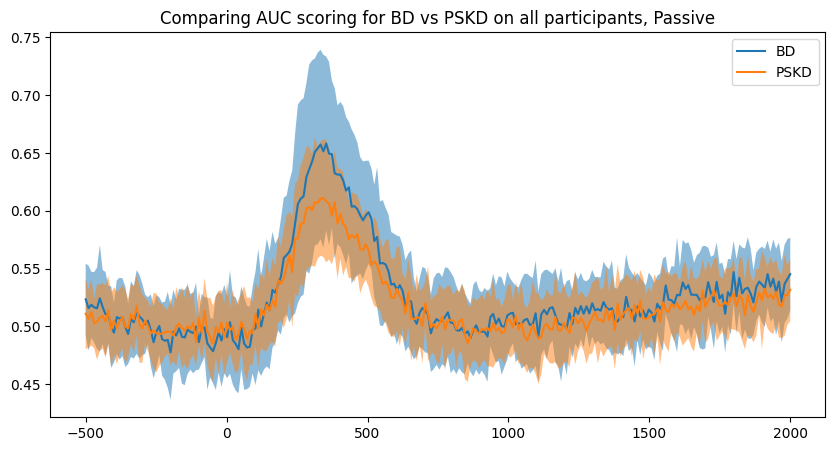

In [31]:

for task in ['Passive']:
    scores_BD = np.load(f'CV_LogReg_OU/LogReg_scores_{task}_BD.npy')
    scores_PSKD = np.load(f'CV_LogReg_OU/LogReg_scores_{task}_PSKD.npy')
    print(scores_BD.shape)
    
    mu_BD, err_BD = np.mean(scores_BD,0), np.std(scores_BD,0)
    mu_PSKD, err_PSKD = np.mean(scores_PSKD,0), np.std(scores_PSKD,0)
    
    times = np.linspace(-500, 2000, 250)
    plt.figure(figsize=(10,5))
    plt.plot(times, mu_BD, label='BD')
    plt.fill_between(times, mu_BD+err_BD, mu_BD-err_BD, alpha=0.5)
    plt.plot(times, mu_PSKD, label='PSKD')
    plt.fill_between(times, mu_PSKD+err_PSKD, mu_PSKD-err_PSKD, alpha=0.5)
    plt.title(f'Comparing AUC scoring for BD vs PSKD on all participants, {task}')
    plt.legend()
    plt.savefig(f'CV_LogReg_OU/LogReg_scores_{task}_BDvsPSKD.png')
    plt.show()

<Figure size 640x480 with 0 Axes>

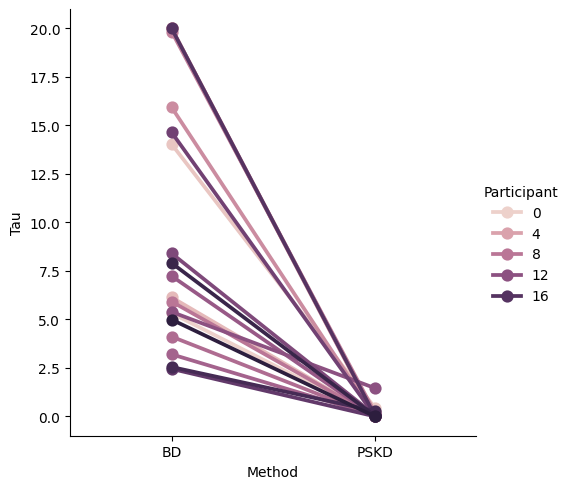

In [42]:
for task in ['Passive']:
    taus_BD = np.load(f'CV_LogReg_OU/taus_{task}_BD.npy')
    taus_PSKD = np.load(f'CV_LogReg_OU/taus_{task}_PSKD.npy')

    data = pandas.DataFrame({
        'Participant': list(range(20))*2,
        'Method': ['BD'] * 20 + ['PSKD'] * 20,
        'Tau': np.concatenate([taus_BD[:,1],taus_PSKD[:,1]])
    })
    
    plt.figure()
    sns.catplot(data=data, x='Method', y='Tau', hue='Participant', kind='point')
    plt.savefig(f'CV_LogReg_OU/taus_{task}_BDvsPSKD.png')
    plt.show()
    